# ATSC 507A: Assignment 2
### Francis Rossmann: 40065154
Submitted Tuesday January 9th, 2021
___
___
___
### Question 1: 
*(5 POINTS) 1 - Using the python version of REBOUND and the REBOUNDx extra forces package, follow the evolution of test particles around Saturn and confirm the analytic expressions in Sections 2.6.2 of the text. Place those test particles at the orbits of Mimas and Encaladus. Report the precession rates as estimated by your simulation and as estimated by the analytic formula in degrees/day and in dimensionless units Ω/n.*
___
### Methodology:
#### Integration for precession: 
A REBOUND simulation is set up with test particles placed at the nominal orbits of Mimas and Enceladus. A Saturn-centered integration is set up to calculate their respective precession rates. The integration is set up such that time units are 'days', length scale is 'AU' and mass is normalized such that $M_{Sun} = 1$. 

Using the rule to limit the integration time step to less than 5% of Mimas's orbital period (~0.96 days) we require a timestep of less than approximately 0.045 days. A time step of $dt = 0.01$ is chosen for this integration. 
___

#### Analytical calculation of precession: 
Precession rate can be calculated analytically given some information about the bodies as:

$$ \dot{\omega} \simeq n_{moon}\frac{3}{2} J_{2}\frac{R^{2}_{Saturn}}{a_{moon}^{2}}- \frac{15}{4} J_{4}\frac{R^{4}_{Saturn}}{a_{moon}^{4}}+\cdots$$

Using the above analytic formula, we can compare the integration results to the predicted values and represent the difference with an error metric. Gravitational harmonics $J_2, J_4$ (retrieved from Table E.15 and E.3, respectively, from the course text) are added for Saturn from REBOUNDx, as well as a the mean equatorial radius of Saturn in AU. These constants are listed below: 

$$ J_2 = 16290.7\cdot10^{-6}$$
$$ J_4 = -936\cdot10^{-6} $$
$$ R_{eq} = 60268 km $$

___
___
___

### The Integration: 

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import reboundx
from mpl_toolkits.mplot3d import Axes3D

if "sim" in locals():
    del sim

# Some handy constants: 
rad2deg = 180.0 / np.pi
deg2rad = np.pi / 180.0
km2AU = 6.685e-9

# Initialize a new simulation: 
sim = rebound.Simulation()
sim.units = ("days", "AU", "MSun")
sim.add("Saturn", hash="saturn")
sim.add(
    m=0,
    a=185539.0 * km2AU,
    e=0.0196,
    inc=1.574 * deg2rad,
    hash="mimas",
) 
sim.add(
    m=0,
    a=238042.0 * km2AU,
    e=0.01,
    inc=0.003 * deg2rad,
    hash="enceladus",
)  
sim.move_to_com()
ps = sim.particles

# Add rebound extras: 
rebx = reboundx.Extras(sim)
gh = rebx.load_force("gravitational_harmonics")
rebx.add_force(gh)

ps["saturn"].params["J2"] = 16290.7e-6
ps["saturn"].params["J4"] = -936e-6
ps["saturn"].params["R_eq"] = 60268 * km2AU

sim.integrator = "whfast"
sim.dt = 0.04
integrationTime = 50
N_outputs = 1000
times = np.linspace(0, integrationTime, N_outputs)

def getPrecessionRate(moon):
    predrate = ps[moon].n * (
        (3 / 2)
        * ps["saturn"].params["J2"]
        * (ps["saturn"].params["R_eq"] / ps[moon].a) ** 2
        - (15 / 4)
        * ps["saturn"].params["J4"]
        * (ps["saturn"].params["R_eq"] / ps[moon].a) ** 4
    )
    predpomega = [predrate * time for time in times]
    predpomega = rad2deg * np.array(predpomega)
    return predpomega % 360

# Integrate for the precession: 
theMoons = ["mimas", "enceladus"]
pomegas = np.zeros((N_outputs, 2))
for i, time in enumerate(times):
    sim.integrate(time)
    for k, moon in enumerate(theMoons):
        pomegas[i, k] = ps[moon].pomega

# This is a coordinate shift from [0 360] to [-180 180] because 
# plotted curves cross the 0=360 degrees in their cycles.
pomegas = (pomegas * rad2deg) % 360
pomegas[pomegas > 180] = pomegas[pomegas > 180] - 360

# Calculate predicted precession: 
predpomega = np.zeros_like(pomegas)
for k, moon in enumerate(theMoons):
    predpomega[:, k] = getPrecessionRate(moon)
predpomega[predpomega > 180] = predpomega[predpomega > 180] - 360



Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).


___
___
___
### Results: 
*Figure 1* below shows the precession of Mimas and Enceladus as a function of time, over a timespan of 50 days. The precession of both Mimas and Enceladus track nicely along their predicted values but show a periodic oscillation about the predicted value (i.e. the *mean* precession of both Mimas and Enceladus is consistent with the analytic results). Because the oscillations cross the $ 0 = 360 $ degrees boundary, the precession values have been shifted from a range of $ 0 < \varpi \leq 360$ degrees to $ -180 < \varpi \leq 180$ degrees. 

The precession rate of Mimas is 0.99 degrees per day.
The precession rate of Enceladus is 0.45 degrees per day. 

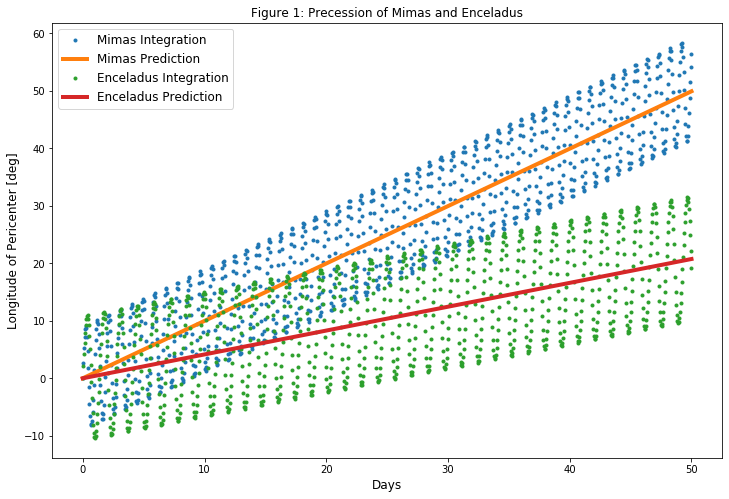

In [72]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(times, pomegas[:,0], ".", label="Mimas Integration")
ax.plot(times, predpomega[:,0], linewidth=4, label="Mimas Prediction")
ax.plot(times, pomegas[:,1], ".", label="Enceladus Integration")
ax.plot(times, predpomega[:,1], linewidth=4, label="Enceladus Prediction")
ax.set_xlabel("Days", fontsize=12)
ax.set_ylabel("Longitude of Pericenter [deg]", fontsize=12)
ax.legend(fontsize=12)
plt.title('Figure 1: Precession of Mimas and Enceladus');

___
___
___
___
___

### Question 2: 
*(10 POINTS) 2 - Considering a series of circular orbits spaced between the exterior of Saturn and orbit of Tritan plot the inclination of Saturn's Laplace plane versus orbital distance from Saturn in units of Saturn radii. Compare the precession rates for these orbits with those determined in part 1. At what distance from Saturn is the analytic determination of the precession rate acurate to 5%?*
___
#### Methodology:
#### Integration set up: 
A REBOUND simulation is set up 20 test particles in linearly spaced orbits of between Enceladus and a nominal Titan orbit. Titan is added manually to the simulation with a parametrization within Saturn's Laplace plane from https://ssd.jpl.nasa.gov/?sat_elem#legend. 

Again, a Saturn-centered integration is set up to calculate orbital variations in time for each test particle. As with before, the time units are 'days', length scale is 'AU' and mass is normalized such that $M_{Sun} = 1$. A time step of $dt = 0.01$ is chosen for this integration. 

*! Test particles are named such that 't1' is the first test particle and is positioned in an orbit closest to that of Enceladus. 't20' is the last test particle and is positioned in an orbit closest to Titan.*


___

#### Solving for the Laplace plane: 
The inclination of the Laplace plane is estimated as a function of distance from Saturn by taking the mean inclination of each test particle over the whole integration time:  
___
#### Precession error: 
Precession is tracked throughout the integration to find the nominal distance from Saturn at which the precession percent error between the predicted and integrated values exceeds 5% with the following formula: 

$$ Err = 100\cdot\frac{(\varpi_{pred} - \varpi_{int})}{\varpi_{pred}}$$ 

Because of the oscillations of $\varpi$ about the mean precession rate (as shown in Figure 1), error estimates are quite large. As a workaround, we can parametrize the mean precession rate as a linear function of time by doing a least squares regression for a solution of the form:

$$\varpi_{LSQ} = c\cdot t + b$$

where $t$ is time and $c, b$ are the fit coefficients. The error estimate is then calculated using the listed equation above as: 

$$ Err = 100\cdot\frac{(\varpi_{pred} - \varpi_{LSQ})}{\varpi_{pred}}$$ 

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import reboundx
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

if "sim" in locals():
    del sim

rad2deg = 180.0 / np.pi
deg2rad = np.pi / 180.0
km2AU = 6.685e-9

sim = rebound.Simulation()
sim.units = ("days", "AU", "MSun")
sim.add("Saturn", hash="saturn")
sim.add(
    m=0,
    a=185539.0 * km2AU,
    e=0.0196,
    inc=1.574 * deg2rad,
    hash="mimas",
) 
sim.add(
    m=0,
    a=238042.0 * km2AU,
    e=0.01,
    inc=0.003 * deg2rad,
    hash="enceladus",
)  # e = 0.01, e from JPL = 0

# Add 'N_testparticle' test particles:
N_testparticle = 10
aRange = np.linspace(sim.particles["enceladus"].a, 0.0075, N_testparticle + 2)
for i, a in enumerate(aRange[1:-1]):
    sim.add(m=0, a=a, e=0.01, inc=0.0001 * deg2rad, hash=("t" + str(i + 1)))

# Add Titan: 
sim.add(
    m=1.3452e23 / 1.989e30,
    a=1221865.0 * km2AU,
    e=0.0288,
    inc=0.306 * deg2rad,
    hash="titan",
)

sim.move_to_com()
ps = sim.particles

rebx = reboundx.Extras(sim)
gh = rebx.load_force("gravitational_harmonics")
rebx.add_force(gh)


# Add J2, J4, R_eq from textbook Appendix:
ps["saturn"].params["J2"] = 16290.7e-6
ps["saturn"].params["J4"] = -936e-6
ps["saturn"].params["R_eq"] = 60268 * km2AU

sim.integrator = "whfast"

sim.dt = 0.01
integrationTime = 100
N_outputs = 1000
times = np.linspace(0, integrationTime, N_outputs)

# List of test particle hashes: 
theMoons = [("t" + str(kk + 1)) for kk in np.arange(N_testparticle)]

# Initialize variables for pomegas, positions and inclinations:
pomegas = np.zeros((N_outputs, np.size(theMoons)))
positions = np.zeros((N_outputs, np.size(theMoons), 3))
inclinations = np.zeros_like(pomegas)

# Integrate for time in times and save pomegas, inclinations, positions:
for i, time in enumerate(times):
    sim.integrate(time)
    for k, moon in enumerate(theMoons):
        pomegas[i, k] = ps[moon].pomega  
        inclinations[i, k] = ps[moon].inc
        positions[i, k, 0] = ps[moon].x
        positions[i, k, 1] = ps[moon].y
        positions[i, k, 2] = ps[moon].z
# Wrap angles to 360 degrees, convert pomegas to a [-180 180] coordinate system:         
inclinations = (inclinations * rad2deg) % 360
pomegas = (pomegas * rad2deg) % 360
pomegas[pomegas > 180] = pomegas[pomegas > 180] - 360

# Loop through test particles and calculate predicted precession: 
predpomega = np.zeros_like(pomegas)
for k, moon in enumerate(theMoons):
    predpomega[:, k] = getPrecessionRate(moon)
    predpomega[:, k] = predpomega[:, k]  # Normalize by orbital frequency
predpomega[predpomega > 180] = predpomega[predpomega > 180] - 360

# Find least-squares regression line for the integration pomega
pomegasLsq = np.zeros_like(predpomega)  
for i, moon in enumerate(theMoons):
    A = np.vstack([times, np.ones(len(times))]).T
    m, c = np.linalg.lstsq(A, pomegas[:, i], rcond=None)[0]
    pomegasLsq[:, i] = [(m * time + c) for time in times]

    # Calculate the error:     
    theDiff = abs(np.mean((predpomega[:, i] - pomegasLsq[:, i]))/np.mean(predpomega[:,i]))
    if theDiff*100 < 25:
        print(
            f"Mean absolute error between LSq fit and prediction for {moon} is {theDiff*100}%"
        )
        print(f"{moon} has semi-major axis = {ps[moon].a}AU\n")


Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).
Mean absolute error between LSq fit and prediction for t1 is 0.47430515920822425%
t1 has semi-major axis = 0.0021284348117843956AU

Mean absolute error between LSq fit and prediction for t2 is 0.47832411007067976%
t2 has semi-major axis = 0.0026655081166094287AU

Mean absolute error between LSq fit and prediction for t3 is 2.6305144810154863%
t3 has semi-major axis = 0.003202470371704507AU

Mean absolute error between LSq fit and prediction for t4 is 16.71198398918305%
t4 has semi-major axis = 0.003739823974888981AU

Mean absolute error between LSq fit and prediction for t5 is 24.93933888999483%
t5 has semi-major axis = 0.004275810540858108AU



---
---
### Results: 
The precession of particles within approximately 0.035 AU of Saturn falls within 5% of their predicted values (see print to screen above). Other simulations (not included) with different semi-major axis spacings for the test particle orbits tend to support this 5% error around 0.0035 AU. 

Now, looking at the inclination of the Laplace plane: (continued below)

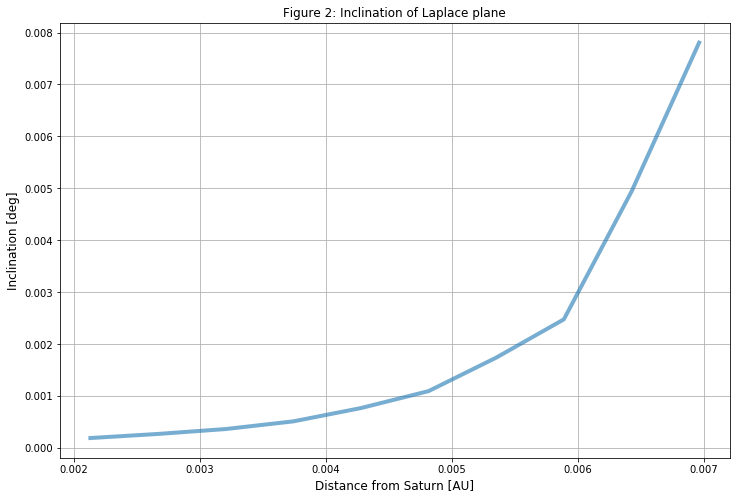

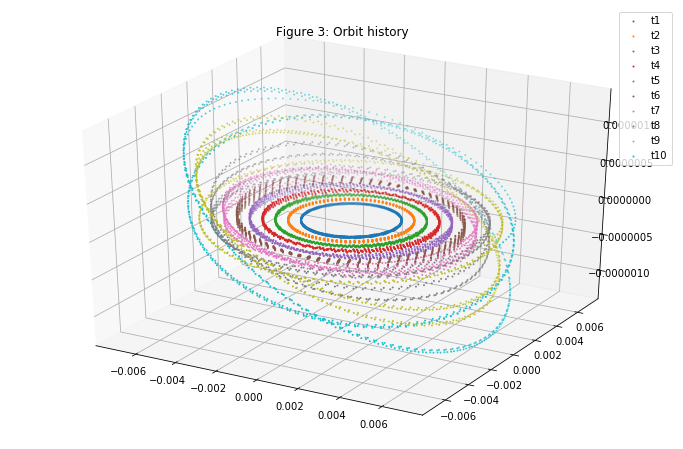

In [74]:
# Plot the inclination of the Laplace place as a function of distance: 
incLaplace = np.mean(inclinations, axis=0)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(aRange[1:-1], incLaplace, alpha=0.6, linewidth=4)
ax.set_xlabel("Distance from Saturn [AU]", fontsize=12)
ax.set_ylabel("Inclination [deg]", fontsize=12)
plt.title("Figure 2: Inclination of Laplace plane")
plt.grid()

#%% Plot the orbits of each test particle 
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

for i in range(N_testparticle):
    ax.scatter(
        positions[:, i, 0], positions[:, i, 1], positions[:, i, 2], label=theMoons[i], s=1
    )
ax.legend()
plt.title('Figure 3: Orbit history')
plt.show()

*Figure 2* above shows the inclination of the Laplace plane as a function of distance from Saturn in AU.
As distance from Saturn increases, the inclination of the Laplace plane increases in the shape of an exponential. Physically, as the test particle approaches the orbit of Titan, it will begin to feel the effects of Titan's potential field increasing with the cube of the separation distance. At a certain threshold distance the effects of Titan's potential begins to dominate in comparison to Saturn's potential, and the particle is pulled into a strong orbital precession. 

___

*Figure 3* shows the orbital history of each particle throughout the simulation, where the outer test particles have clearly been pulled into precession and have developed large inclinations with respect to Saturn's Laplace plane. Conversely the particles in the inner orbitals remain well behaved and do not experience this precession. The inclination of the orbits can clearly be seen increasing with distance from Saturn. Titan is not pictured. 
___

*Figure 4* below shows the precession of the first three test particles (for which the relative error between predicted and observed values falls under 5%. The precession rates for these particles (and all particles in this simulation) are smaller than those observed in Question 1. 

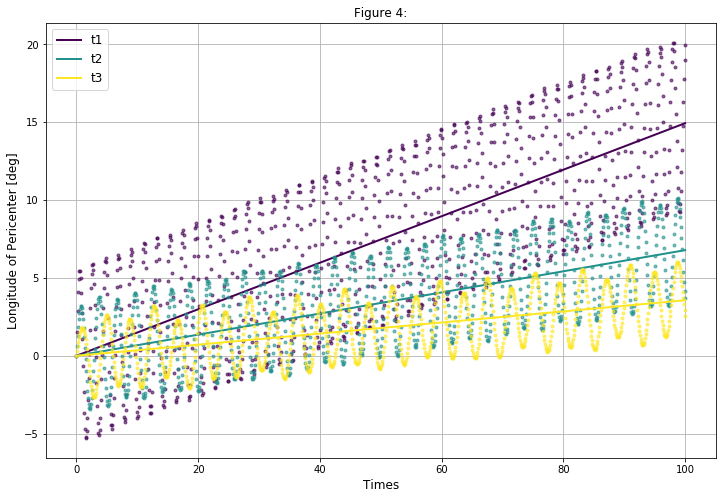

In [75]:
numOrbits = 3

viridis = cm.get_cmap("viridis", numOrbits)

fig, ax = plt.subplots(figsize=(12, 8))
for ii in range(numOrbits):
    ax.plot(
        times,
        pomegas[:, ii],
        ".",
        alpha=0.6,
        color=viridis.colors[ii, :],
    )
    ax.plot(
        times,
        predpomega[:, ii],
        linewidth=2,
        label=(theMoons[ii]),
        color=viridis.colors[ii, :],
    )
ax.set_xlabel("Times", fontsize=12)
ax.set_ylabel("Longitude of Pericenter [deg]", fontsize=12)
ax.legend(fontsize=12)
plt.title(("Figure 4:"))
plt.grid()

*Figure 5* below shows the precession for the first 6 particles in the simulation (including the prior three). The solid lines represent the predicted values, and the scatter represents the results from the integration. We can see that the closeness of fit to the predicted values falls off with increasing distance from Saturn. Additional test particles can be added to the figure below by increasing the value of '''numOrbits''' in the cell below.

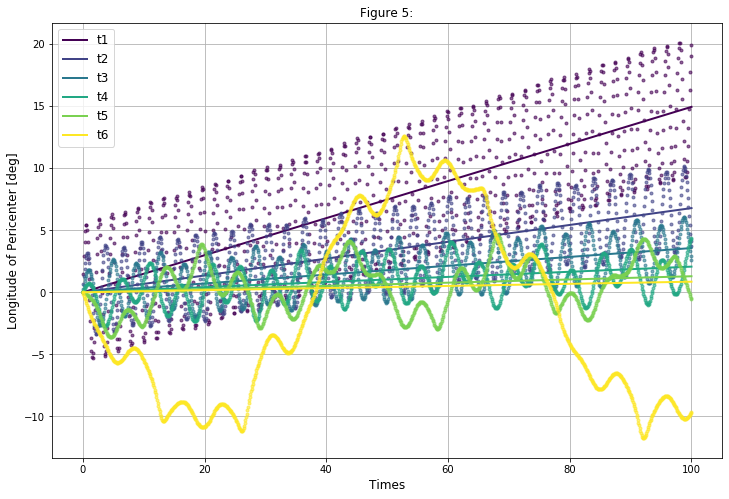

In [76]:
numOrbits = 6

viridis = cm.get_cmap("viridis", numOrbits)

fig, ax = plt.subplots(figsize=(12, 8))
for ii in range(numOrbits):
    ax.plot(
        times,
        pomegas[:, ii],
        ".",
        alpha=0.6,
        color=viridis.colors[ii, :],
    )
    ax.plot(
        times,
        predpomega[:, ii],
        linewidth=2,
        label=(theMoons[ii]),
        color=viridis.colors[ii, :],
    )
ax.set_xlabel("Times", fontsize=12)
ax.set_ylabel("Longitude of Pericenter [deg]", fontsize=12)
ax.legend(fontsize=12)
plt.title(("Figure 5:"))
plt.grid()